# **Homework 1 - Image Colorization**

<div style="border: 3px solid #222; padding: 16px; border-radius: 10px; background-color: #1c1f26; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; color: #e0e0e0;">
  <div style="display: flex; align-items: center; gap: 8px; margin-top: 12px;">
    <span style="font-size: 24px; color: #ff5555;">&#128274;</span>
    <span style="font-size: 16px;"><strong>Project:</strong> Homeworks</span>
  </div>
  <div style="display: flex; align-items: center; gap: 8px; margin-top: 8px;">
    <span style="font-size: 20px; color: #ff5555;">&#128218;</span>
    <span style="font-size: 16px;"><strong>Course:</strong> Deep Network Development</span>
  </div>
  <div style="margin-top: 12px; font-size: 14px;">
    <span style="font-size: 18px; color: #6e8192;">&#128100;</span>
    <span style="font-weight: bold;"><strong>Authors:</strong></span> Tamás Takács, Imre Molnár (PhD students, Department of Artificial Intelligence, Eötvös Loránd University)
  </div>
</div>
<hr style="border: none; border-top: 2px solid #444;">
<br>

<img src="https://learnopencv.com/wp-content/uploads/2018/07/colorization-example.png" alt="1" border="0">

This notebook contains the required task for the **first homework** of the **Deep Network Development (DNDEG)** course. Read the task description carefully and **fill in the empty code cells**.

# **Task Description**

`Image Colorization` is the process of converting a grayscale image (single-channel) into an image with a specific color spectrum. In this homework, your task is to **create and train a convolutional neural network (CNN) model** to colorize grayscale images to the RGB color spectrum. To demonstrate the effectiveness of CNNs, you will also implement a **linear regression model** for the same task and compare their results.

## **Expectations**

- The **performance does not need to be perfect**, but your **metrics should show better results than random color guessing**, and the **loss should decrease throughout the epochs**.
- You are **free to design any custom shallow convolutional neural network**, as long as it is specifically tailored for the image colorization task.
- You can choose **any dataset** (e.g., `CIFAR-10`, `Caltech101`, `Food101`, `FlickR`) or create a custom dataset by **scraping the web** for a specific theme. If you decide to use web scraping, you can utilize the `icrawler` Python package. Ensure that **no NSFW images** are included.
- If you decide to use a **high-resolution dataset**, apply **resizizing transformations** since the fully connected network’s complexity increases with input size. For example:
  - A $[1\times32\times32]$ grayscale image will have $1,024$ features.
  - A $[1\times512\times512]$ grayscale image will have $262,144$ features, which is $256$ **times more**.
  
## **Requirements**

- Data Visualization:
  - Display **samples from the original dataset**.
  - Show the **transformed grayscale images** at the beginning of the notebook.
  - Present **predicted colorized images** alongside ground truth images.

- Performance Monitoring:
  - **Visualize training and validation losses** after training the network.
  - **Use plots and metrics (e.g., matplotlib, seaborn)** to display performance trends.

- Implement **overfitting prevention techniques**, such as:
  - **Early stopping**
  - **Regularization techniques**
  - **Experimenting with different loss functions**
  - Save the **best-performing model** during training.

- Compare model performance:
  - **Visualize predictions** on a batch of test images.
  - Calculate and display **batch losses for both FCN and CNN models**.
  - Explain why the models perform as they do, **highlighting the strengths and weaknesses** of each approach.

- Visualizing:
  - **Feature Maps** of the CNN model
  - **Weights** of the FCN model

- Optionally, use **WandB (Weights and Biases)** or **TensorBoard** to:
  - Track and visualize **training progress**.
  - Monitor **model performance** over time.
  - Log **key metrics**.

**Name:** Benmadi imed-eddine

**Project Github Reposotry:** [https://github.com/imadbenmadi/Image-Coloration](https://github.com/imadbenmadi/Image-Coloration)




## **0. Necessary Imports**
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import urllib.request
import tarfile
import zipfile
import pickle
from colorama import init, Fore, Style
import shutil

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


## **1. Data Loading Process**

If you're unsure which dataset to use, **PyTorch** provides a collection of **pre-built datasets** in its [documentation](https://pytorch.org/vision/main/datasets.html). Look for a dataset under the *Image Classification* section that contains colored images.

**Caltech-101:**

<img src=" https://datasets.activeloop.ai/wp-content/uploads/2022/09/Caltech-101-dataset-main-image.webp" alt="1" border="0">

**CIFAR-10:**

<img src=" https://datasets.activeloop.ai/wp-content/uploads/2022/09/CIFAR-10-dataset-Activeloop-Platform-visualization-image-1.webp" alt="1" border="0">

**Food-101:**

<img src=" https://storage.googleapis.com/kaggle-datasets-images/2918922/5029790/277a9147ec4854e4762767c8bd107bec/dataset-card.png?t=2023-02-20-08-37-14" alt="1" border="0">




## Data Extraction

**This script downloads, extracts, and processes datasets (Caltech-101, Food-101, CIFAR-10) with progress tracking and integrity checks .ript downloads, extracts, and processes datasets (Caltech-101, Food-101, CIFAR-10) with progress tracking and integrity checks.
It converts CIFAR-10 batch files to individual images and ensures datasets are available locally or re-downloads them if necessary**

In [113]:
# Initialize colorama with autoreset for better compatibility across platforms
init(autoreset=True)

data_dir = "./data"

dataset_links = {
    "caltech-101": {
        "url": "https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1",
        "description": "101 categories of objects, ~9K images"
    },
    "food101": {
        "url": "http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz",
        "description": "101 food categories, 101K images"
    },
    "cifar-10-batches-py": { 
        "url": "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz", 
        "description": "10 classes, 60K 32x32 color images"
    } 
}

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_with_progress(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc="Downloading") as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def extract_file(file_path, extract_dir):
    print(f"{Fore.GREEN}Extracting files...{Style.RESET_ALL}")
    
    if file_path.endswith('.tar.gz'):
        with tarfile.open(file_path, "r:gz") as tar:
            tar.extractall(path=extract_dir)
    elif file_path.endswith('.zip') or file_path.endswith('.zip?download=1'):
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
    
    os.remove(file_path)

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10(data_dir="./data/cifar-10-batches-py"):
    images = []
    labels = []
    
    # Load training batches (5 files)
    for i in range(1, 6):
        batch = unpickle(os.path.join(data_dir, f"data_batch_{i}"))
        images.append(batch[b'data'])
        labels += batch[b'labels']

    # Convert to numpy array
    images = np.vstack(images).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    labels = np.array(labels)

    # Load test batch
    test_batch = unpickle(os.path.join(data_dir, "test_batch"))
    test_images = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    test_labels = np.array(test_batch[b'labels'])

    print(f"{Fore.GREEN}✅ CIFAR-10 dataset loaded successfully!{Style.RESET_ALL}")
    return (images, labels), (test_images, test_labels)

def save_images_from_cifar10(data_dir="./data/cifar-10-batches-py", output_dir="./data/cifar10_images"):
    os.makedirs(output_dir, exist_ok=True)
    
    # Load and save training batches
    with tqdm(total=60000, desc="Saving CIFAR-10 Images", unit="img") as pbar:
        for i in range(1, 6):
            batch_file = os.path.join(data_dir, f"data_batch_{i}")
            if not os.path.exists(batch_file):
                print(f"{Fore.YELLOW}Warning: {batch_file} not found, skipping.{Style.RESET_ALL}")
                continue
                
            batch = unpickle(batch_file)
            images = batch[b'data']
            for j in range(len(images)):
                img = images[j].reshape(3, 32, 32).transpose(1, 2, 0)
                img = Image.fromarray(img)
                img.save(os.path.join(output_dir, f"train_{i}_{j}.png"))
                pbar.update(1)

        # Load and save test batch
        test_batch_file = os.path.join(data_dir, "test_batch")
        if os.path.exists(test_batch_file):
            test_batch = unpickle(test_batch_file)
            test_images = test_batch[b'data']
            for j in range(len(test_images)):
                img = test_images[j].reshape(3, 32, 32).transpose(1, 2, 0)
                img = Image.fromarray(img)
                img.save(os.path.join(output_dir, f"test_{j}.png"))
                pbar.update(1)
        else:
            print(f"{Fore.YELLOW}Warning: test_batch not found, skipping.{Style.RESET_ALL}")
    
    # Delete original batch files if they exist
    cifar_dir = os.path.join(data_dir, "cifar-10-batches-py")
    if os.path.exists(cifar_dir):
        try:
            shutil.rmtree(cifar_dir)
            print(f"{Fore.GREEN}✅ Original CIFAR-10 batch files removed{Style.RESET_ALL}")
        except Exception as e:
            print(f"{Fore.YELLOW}Warning: Could not remove {cifar_dir}: {str(e)}{Style.RESET_ALL}")

    print(f"{Fore.GREEN}✅ CIFAR-10 images saved to {output_dir}{Style.RESET_ALL}")

def download_dataset(dataset_name, url, output_dir=data_dir):
    print(f"{Fore.YELLOW}Downloading {dataset_name}...{Style.RESET_ALL}")
    os.makedirs(output_dir, exist_ok=True)
    file_ext = '.zip' if url.endswith('.zip?download=1') or url.endswith('.zip') else '.tar.gz'
    archive_path = os.path.join(output_dir, f"{dataset_name}{file_ext}")
    dataset_path = os.path.join(output_dir, dataset_name)
    
    try:
        download_with_progress(url, archive_path)
        extract_file(archive_path, output_dir)
        
        # Special handling for CIFAR-10
        cifar_dir = os.path.join(data_dir, "cifar-10-batches-py")
        if dataset_name == "cifar-10-batches-py" and os.path.exists(cifar_dir):
            cifar_img_dir = os.path.join(data_dir, "cifar10_images")
            if not os.path.exists(cifar_img_dir):
                # Check required batch files exist
                required_batches = [f"data_batch_{i}" for i in range(1, 6)] + ["test_batch"]
                missing_batches = [batch for batch in required_batches if not os.path.exists(os.path.join(cifar_dir, batch))]
                
                if missing_batches:
                    print(f"{Fore.RED}Missing CIFAR-10 batches: {', '.join(missing_batches)}{Style.RESET_ALL}")
                    return None
                    
                # Convert CIFAR batch files to individual images
                (train_images, train_labels), (test_images, test_labels) = load_cifar10(cifar_dir)
                print(f"{Fore.GREEN}Processing CIFAR-10: {train_images.shape[0]} training, {test_images.shape[0]} test images{Style.RESET_ALL}")
                save_images_from_cifar10(cifar_dir, cifar_img_dir)
                return cifar_img_dir
                
        print(f"{Fore.GREEN}✅ {dataset_name} downloaded and extracted{Style.RESET_ALL}")
        return dataset_path
        
    except Exception as e:
        print(f"{Fore.RED}Error processing {dataset_name}: {str(e)}{Style.RESET_ALL}")
        return None

def get_dataset(dataset_name):
    # For CIFAR-10, check the processed image directory
    if dataset_name == "cifar-10-batches-py":
        img_path = os.path.join(data_dir, "cifar10_images")
        if os.path.exists(img_path) and os.listdir(img_path):
            print(f"{Fore.GREEN}✅ CIFAR-10 images found locally{Style.RESET_ALL}")
            return img_path
    else:
        local_path = os.path.join(data_dir, dataset_name)
        if os.path.exists(local_path) and os.path.isdir(local_path):
            # Additional check for food101
            if dataset_name == "food101" and not os.path.exists(os.path.join(local_path, "images")):
                print(f"{Fore.YELLOW}Food-101 dataset missing images directory. Re-downloading...{Style.RESET_ALL}")
            else:
                print(f"{Fore.GREEN}✅ Dataset {dataset_name} found locally{Style.RESET_ALL}")
                return local_path
    
    # Dataset not found or invalid, download it
    if dataset_name in dataset_links:
        return download_dataset(dataset_name, dataset_links[dataset_name]["url"])
    else:
        print(f"{Fore.RED}Error: Unknown dataset {dataset_name}{Style.RESET_ALL}")
        return None

def check_dataset_integrity():
    """Check if downloaded datasets are valid and complete"""
    issues = []
    
    # Check FOOD-101
    food_path = os.path.join(data_dir, "food101")
    if os.path.exists(food_path):
        if not os.path.exists(os.path.join(food_path, "images")):
            issues.append("Food-101 missing images directory")
            try:
                shutil.rmtree(food_path)
                print(f"{Fore.YELLOW}Removed invalid Food-101 dataset{Style.RESET_ALL}")
            except:
                pass
    
    # Check CIFAR-10
    cifar_img_path = os.path.join(data_dir, "cifar10_images")
    cifar_batch_path = os.path.join(data_dir, "cifar-10-batches-py")
    
    # If batch files exist but images don't, convert them
    if os.path.exists(cifar_batch_path) and not os.path.exists(cifar_img_path):
        print(f"{Fore.YELLOW}CIFAR-10 batch files found but no images. Converting...{Style.RESET_ALL}")
        try:
            (train_images, _), (test_images, _) = load_cifar10(cifar_batch_path)
            save_images_from_cifar10(cifar_batch_path)
        except Exception as e:
            issues.append(f"CIFAR-10 conversion failed: {str(e)}")
            try:
                if os.path.exists(cifar_batch_path):
                    shutil.rmtree(cifar_batch_path)
            except:
                pass
    
   
    
    return issues

def main():
    print(f"{Fore.CYAN}=== Dataset Extraction ===")
    
    # Create data directory if needed
    os.makedirs(data_dir, exist_ok=True)
    
    # Print available datasets
    print(f"{Fore.WHITE}Available datasets:")
    for name, info in dataset_links.items():
        print(f"- {name}: {info['description']}")
    print("-------------------------")
    
    # Check dataset integrity and clean up bad downloads
    issues = check_dataset_integrity()
    if issues:
        print(f"{Fore.YELLOW}Fixed {len(issues)} dataset issues{Style.RESET_ALL}")
    
    # Download/verify all datasets
    dataset_paths = {}
    for name in dataset_links.keys():
        dataset_paths[name] = get_dataset(name)
    
    # Summary
    print(f"\n{Fore.GREEN}Dataset access summary:")
    for name, path in dataset_paths.items():
        print(f"- {name}: {'✅ Available' if path else '❌ Failed'}")
    
    print(f"{Fore.CYAN}=== Dataset Extraction Complete ===")

if __name__ == "__main__":
    main()

=== Dataset Extraction ===
Available datasets:
- caltech-101: 101 categories of objects, ~9K images
- food101: 101 food categories, 101K images
- cifar-10-batches-py: 10 classes, 60K 32x32 color images
-------------------------
✅ Dataset caltech-101 found locally
✅ Dataset food101 found locally
✅ CIFAR-10 images found locally

Dataset access summary:
- caltech-101: ✅ Available
- food101: ✅ Available
- cifar-10-batches-py: ✅ Available
=== Dataset Extraction Complete ===


## **2. Defining Augmentations**

Since most datasets and images are in RGB color space, you'll need to convert them to grayscale. However, we **strongly recommend** against applying the grayscale transformation immediately after loading the dataset, as this would result in losing the original colored images (which serve as the target). Instead, apply essential preprocessing steps like `tensor conversion`, `normalization` and `resizing` first, and **only perform the grayscale transformation within the custom Dataset class** to retain access to both input (grayscale) and target (RGB) images.

In [114]:
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

**The data folder contain more than 160000 image and I could not process them all in my laptop so we will work with a portion of the dataset , the food101 apple_pie folder caintain a good number of images and easy to process .**

In [115]:
training_data_path = "./data/food101/images/apple_pie"

if not os.path.exists(training_data_path):
    print(f"{Fore.RED}Error: Training data not found at {training_data_path}{Style.RESET_ALL}")
    print(f"{Fore.YELLOW}Please run the dataset download cell above to fetch the CIFAR-10 dataset{Style.RESET_ALL}")

num_images = len(os.listdir(training_data_path))
print(f"Number of images in the training dataset: {num_images}")

Number of images in the training dataset: 1000


## **3. Creating Datasets and Dataloaders**

To train a custom object detection model, a dataset is required. For this assignment, you will create a **custom dataset class** that takes a dataset path as input and returns **input-output** image pairs when batched through a `Dataloader`:

- **Input:** $[1\times H \times W]$ grayscale image  
- **Output:** $[3\times H \times W]$ RGB image  

Use the built-in **`transforms.Grayscale`** method from `torchvision.transforms` to convert images to grayscale.

> **Note:** The $W$ and $H$ dimensions do not necessarily have to be the same.

For the **DataLoader**, ensure that the **batch size** is appropriate so that it fits into memory. Set the **`shuffle`** parameter as follows:

- **Training & Validation DataLoaders:** `shuffle=True` (to randomize the order of samples)  
- **Test DataLoader:** `shuffle=False` (to maintain consistency in evaluation)

```python
class GrayscaleToColorDataset(Dataset):
    def __init__(self):
        raise NotImplementedError
    
    def __len__(self):
        raise NotImplementedError

    def __getitem__(self, idx):
        raise NotImplementedError
```

In [116]:
class GrayscaleToColorDataset(Dataset):
    def __init__(self, root_dir, transform=None, img_size=128):
        self.root_dir = root_dir
        self.image_files = []
        self.img_size = img_size
        
        # Find all image files
        for subdir, _, files in os.walk(root_dir):
            for file in tqdm(files, desc="Loading images"):
                if file.endswith(".jpg") or file.endswith(".png"):
                    self.image_files.append(os.path.join(subdir, file))
        
        print(f"Found {len(self.image_files)} images.")
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        
        # Resize image to the specified size
        resize_transform = transforms.Resize((self.img_size, self.img_size))
        image = resize_transform(image)
        
        # Convert to grayscale
        grayscale_transform = transforms.Grayscale(num_output_channels=1)
        grayscale_image = grayscale_transform(image)

        # Apply additional transforms if specified
        if self.transform:
            image = self.transform(image)
            grayscale_image = self.transform(grayscale_image)

        return grayscale_image, image


**Define a function to split the dataset**

In [117]:
def split_dataset(full_dataset, train_ratio=0.8):
    train_size = int(train_ratio * len(full_dataset))
    val_size = len(full_dataset) - train_size
    
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size]
    )
    
    print(f"Training set size: {len(train_dataset)}, Validation set size: {len(val_dataset)}")
    return train_dataset, val_dataset


In [118]:
# Create dataset with explicit image size
img_size = 128  # Use the same size for dataset and models
dataset = GrayscaleToColorDataset(training_data_path, transform=transforms.ToTensor(), img_size=img_size)

# Split dataset
train_dataset, val_dataset = split_dataset(dataset)

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Loading images: 100%|██████████| 1000/1000 [00:00<00:00, 253462.90it/s]


Found 1000 images.
Training set size: 800, Validation set size: 200


## **4.1 Visualize Training Data**

To visualize the training data, extract a batch from the training `DataLoader` and plot the **input-output** pairs using `Matplotlib` or `Seaborn`. Ensure that at least **8 pairs** are displayed for a clear representation.

```python
def visualize_batch():
  raise NotImplementedError
```

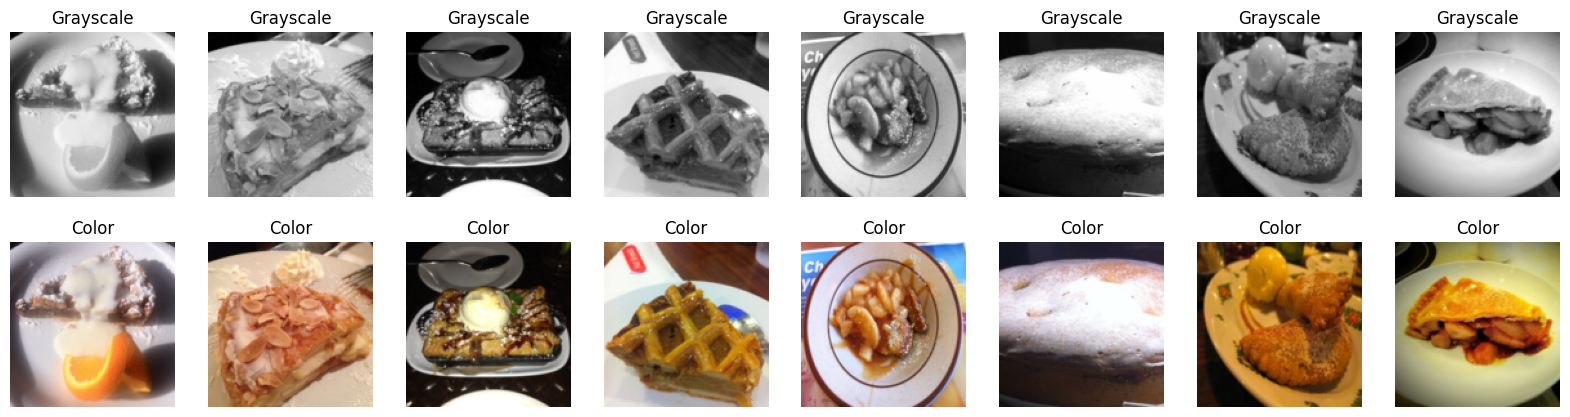

In [119]:
def visualize_batch(dataloader):
    data_iter = iter(dataloader)
    grayscale_images, color_images = next(data_iter) 
    
    fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(20, 5))
    
    for i in range(8):
        # Grayscale images
        axes[0, i].imshow(grayscale_images[i].squeeze().numpy(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Grayscale')
        
        # Color images
        axes[1, i].imshow(np.transpose(color_images[i].numpy(), (1, 2, 0)))
        axes[1, i].axis('off')
        axes[1, i].set_title('Color')
    
    plt.show()

visualize_batch(train_loader)


## **4.2 Creating a CNN Model**

You are free to design your CNN using any combination of:
- `Conv2d` layers
- `MaxPool2d`
- Normalization techniques (e.g., `BatchNorm`, `Dropout`)
- Activation functions (e.g., `ReLU`, `LeakyReLU`, etc.)

The final convolutional layer should output a tensor of shape $[3 × H × W]$ to match the RGB color space. Apply a `sigmoid` activation at the end to constrain the output values between **0 and 1**, allowing for later **denormalization** to the full RGB scale.

For an **extra grade improvement**, explore more advanced architectures and techniques:

- **Dilation in Conv2D layers:** Expands the receptive field without increasing parameters.  
  [PyTorch Docs on Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)  

- **Transpose Convolutions:** Used for upsampling to restore spatial dimensions in an image.  
  [PyTorch Docs on ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)  

- **Encoder-Decoder Models & UNets:** Popular in segmentation and image-to-image translation tasks.  
  [Understanding UNet](https://towardsdatascience.com/understanding-u-net-61276b10f360/)  

- **Generative Adversarial Networks (GANs):** Used for high-quality image generation and colorization.  
  [Introduction to GANs](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)  

```python
class ColorizationCNN(nn.Module):
    def __init__(self):
        super(ColorizationCNN, self).__init__()
        raise NotImplementedError

    def forward(self, x):
        raise NotImplementedError
```

### Encoder and Decoder:

- **Encoder**: The encoder extracts important features from the input grayscale image. It consists of several convolutional layers followed by ReLU activations, batch normalization (for stability), and max-pooling (to reduce spatial dimensions). This part compresses the image into a feature representation.

- **Decoder**: The decoder reconstructs the colorized image from the encoded features. It uses **transposed convolutions** (upsampling) to restore the spatial dimensions, followed by additional convolutional layers to refine the output. A final **Sigmoid activation** ensures pixel values are in the range \([0,1]\) for the RGB output.

This model essentially **learns to add color** to grayscale images by mapping input intensities to color values. 

In [120]:
class ColorizationCNN(nn.Module):
    def __init__(self):
        super(ColorizationCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),  # Improves stability
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),  # More stability
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # Extra conv for refinement
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # Extra conv for refinement
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ColorizationCNN()
print(model)


ColorizationCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(128, 64, kernel_s

## **4.3 Creating a FCN Model**

The fully connected network should process an **input grayscale image** and transform it into an RGB image by following these steps:

1. **Flatten the input:**  
   - Convert the image into a vector of shape $[N, 1 * H * W]$, where $N$ is the batch size.
   
2. **Linear Projection:**  
   - Apply a **fully connected (linear) layer** that projects the input vector to a space of $[N, 3 * H * W]$.

3. **Reshape the output:**  
   - Reshape the result back into an image format with shape $[N, 3, H, W]$, matching the expected RGB output.

Feel free to add **more hidden layers** and incorporate **non-linear activation functions**, normalization techniques, and other enhancements to help the model learn more expressive and complex features.



In [121]:
class ColorizationLinear(nn.Module):
    def __init__(self, img_size=256):  # Adjust size as needed
        super(ColorizationLinear, self).__init__()
        
        # Calculate dimensions
        input_dim = img_size * img_size  
        output_dim = input_dim * 3  # RGB output size
        
        # Define layers
        self.fc1 = nn.Linear(input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, output_dim)
        
        # Activations and regularization
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        
        # Store image size for reshape operations
        self.img_size = img_size

    def forward(self, x):
        # Get batch size
        batch_size = x.size(0)
        
        # Flatten input - make sure we're flattening to the right dimensions
        x = x.view(batch_size, -1)  # Flatten input to [batch_size, img_size^2]
        
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.sigmoid(self.fc3(x))
        
        # Reshape to [batch_size, 3, img_size, img_size]
        x = x.view(batch_size, 3, self.img_size, self.img_size)
        return x
model = ColorizationLinear(img_size=128)
print(model)

ColorizationLinear(
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=49152, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)


## **5.1 Plotting Model Parameter Count and Size**

A convenient way to inspect the number of parameters in a defined `nn.Module` is by using the `torchsummary` package. This package provides a detailed summary of the model architecture, including the number of parameters in each layer, their shapes, and the total parameter count.

To use `torchsummary`, you need to pass a dummy tensor with the specified input shape. The package will then traverse the model, layer by layer, calculating the total number of trainable and non-trainable parameters while also displaying the output shapes at each stage.

Sumnmarize **both models**!

```python
model_cnn = ColorizationCNN().to(device)
summary(model_cnn, input_size = )
```

In [122]:

model_cnn = ColorizationCNN().to(device)
summary(model_cnn, input_size=(1, 128, 128))

model_fcn = ColorizationLinear(img_size=128).to(device)
summary(model_fcn, input_size=(1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
              ReLU-2         [-1, 64, 128, 128]               0
         MaxPool2d-3           [-1, 64, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]          73,856
              ReLU-5          [-1, 128, 64, 64]               0
       BatchNorm2d-6          [-1, 128, 64, 64]             256
         MaxPool2d-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 256, 32, 32]         295,168
              ReLU-9          [-1, 256, 32, 32]               0
      BatchNorm2d-10          [-1, 256, 32, 32]             512
        MaxPool2d-11          [-1, 256, 16, 16]               0
  ConvTranspose2d-12          [-1, 128, 32, 32]         131,200
             ReLU-13          [-1, 128, 32, 32]               0
           Conv2d-14          [-1, 128,

In [123]:
criterion = nn.MSELoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)
optimizer_fcn = optim.Adam(model_fcn.parameters(), lr=0.001)

## **5.2 Defining Loss Function and Optimizer**

**Loss Functions and their options:**

For our grayscale-to-color image translation task, we are performing **regression** rather than classification. Our network predicts continuous RGB values for each pixel, meaning that the chosen loss function should effectively measure the difference between the predicted and true color values.

---

### **a. Mean Squared Error (MSE) Loss**
MSE loss is a standard choice for regression tasks as it penalizes larger errors more strongly than smaller ones. It is computed as:

$$
\mathcal{L}_{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2
$$

where $ y_i $ is the ground truth pixel value and $ \hat{y}_i $ is the predicted pixel value.

- **Pros:** Simple, commonly used for regression, computationally efficient.
- **Cons:** Sensitive to outliers since it squares errors.

---

### **b. Root Mean Squared Error (RMSE) Loss**
RMSE is simply the square root of MSE, reducing the impact of squared errors and providing a more interpretable loss value in the same unit as the output.

$$
\mathcal{L}_{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}
$$

- **Pros:** Less sensitive to large errors compared to MSE, more interpretable.
- **Cons:** Still punishes large errors significantly.

---

### **c. Huber Loss**
Huber Loss is a combination of MSE and Mean Absolute Error (MAE) that is more robust to outliers. It applies MSE for small errors and MAE for large ones:

$$
\mathcal{L}_{Huber} =
\begin{cases}
\frac{1}{2} (y_i - \hat{y}_i)^2, & \text{if} \ |y_i - \hat{y}_i| \leq \delta \\
\delta (|y_i - \hat{y}_i| - \frac{1}{2} \delta), & \text{otherwise}
\end{cases}
$$

where $ \delta $ is a threshold defining the transition from quadratic to linear loss.

- **Pros:** Robust to outliers while still penalizing significant errors.
- **Cons:** Introduces an extra hyperparameter $ \delta $ that must be tuned.

---

### **d. Structural Similarity Index (SSIM) Loss (Advanced)**
While MSE and Huber loss work on a per-pixel basis, SSIM measures **perceptual similarity** between two images. It compares contrast, structure, and luminance.

$$
\mathcal{L}_{SSIM} = 1 - SSIM(y, \hat{y})
$$

where SSIM measures image similarity in a windowed manner.

- **Pros:** Better reflects human perception of image quality.
- **Cons:** More computationally expensive.

---

[PyTorch Documentation](https://pytorch.org/docs/stable/nn.html#loss-functions)

---

**Optimizers and their options:**

There are some pre-built [Optimizers in PyTorch](https://pytorch.org/docs/stable/optim.html), they are sufficient in most cases, especially if their parameters are well set. The two most well-known are Adam (AdamW) and SGD, both of which originate from Gradient Descent, which we implemented earlier.

* **S**tochastic **G**radient **D**escent ([SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html))
* **ADA**ptive **M**oment optimizer ([ADAM](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html))
* [A good general overview](https://www.ruder.io/optimizing-gradient-descent/)

**Define a function to split the dataset**

In [124]:
def split_dataset(full_dataset, train_ratio=0.8):
    train_size = int(train_ratio * len(full_dataset))
    val_size = len(full_dataset) - train_size
    
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size]
    )
    
    print(f"Training set size: {len(train_dataset)}, Validation set size: {len(val_dataset)}")
    return train_dataset, val_dataset

# Split the dataset
train_dataset, val_dataset = split_dataset(dataset)

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # Using validation set as test for simplicity

print(f"Number of batches - Training: {len(train_loader)}, Validation: {len(val_loader)}")

Training set size: 800, Validation set size: 200
Number of batches - Training: 50, Validation: 13


**this is a more improved way to train the model**

In [ ]:


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15, patience=3, max_batches=200):
    model.train()
    train_losses, val_losses = [], []
    best_loss = float('inf')
    patience_counter = 0
    model_name = model.__class__.__name__  

    scaler = torch.amp.GradScaler(device="cuda")  

    for epoch in range(num_epochs):
        running_train_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=max_batches, desc=f"Epoch {epoch+1}/{num_epochs}")

        for i, (grayscale_images, color_images) in progress_bar:
            if i >= max_batches:
                break  

            grayscale_images, color_images = grayscale_images.to(device), color_images.to(device)

            optimizer.zero_grad()

            with torch.amp.autocast(device_type="cuda"):
                outputs = model(grayscale_images)
                loss = criterion(outputs, color_images)

            scaler.scale(loss).backward()  
            scaler.step(optimizer)
            scaler.update()

            running_train_loss += loss.item() * grayscale_images.size(0)
            progress_bar.set_postfix(loss=loss.item())

        epoch_train_loss = running_train_loss / (max_batches * train_loader.batch_size)
        train_losses.append(epoch_train_loss)

        # Validation Step
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for grayscale_images, color_images in val_loader:
                grayscale_images, color_images = grayscale_images.to(device), color_images.to(device)

                with torch.amp.autocast(device_type="cuda"):
                    outputs = model(grayscale_images)
                    loss = criterion(outputs, color_images)

                running_val_loss += loss.item() * grayscale_images.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

        # Save Best Model
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            patience_counter = 0
            checkpoint_filename = f"{model_name}_best_model.pt"
            try:
                torch.save({
                    'model_state_dict': model.state_dict(), 
                    'epoch': epoch+1, 
                    'val_loss': best_loss,
                    'train_losses': train_losses,
                    'val_losses': val_losses
                }, checkpoint_filename)
                print(f"Model checkpoint saved to {checkpoint_filename}")
            except Exception as e:
                print(f"Error saving checkpoint: {str(e)}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break  
             
    return train_losses, val_losses



**defining the test model**

In [126]:
def test_model(model, test_loader, criterion):
    model.eval()  # Set model to evaluation mode (turns off dropout, etc.)
    test_loss = 0.0

    with torch.no_grad():  # Disable gradient calculations for efficiency
        for grayscale_images, color_images in test_loader:
            grayscale_images, color_images = grayscale_images.to(device), color_images.to(device)
            outputs = model(grayscale_images)
            loss = criterion(outputs, color_images)
            test_loss += loss.item() * grayscale_images.size(0)  # Accumulate weighted loss

    # Calculate average loss over entire dataset
    test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')
    
    return test_loss  

## **6. Training the Image Colorization Models**

When implementing the training loop, ensure the following key aspects are included:

- Set an **appropriate number of epochs** for model training, balancing between underfitting and overfitting.
- Maintain running losses throughout each epoch and compute both **training loss** and **validation loss** per epoch.
- Implement an **early stopping mechanism** to halt training if validation loss stops improving, preventing unnecessary overfitting.
- **Save the model at its best-performing epoch** based on validation loss, ensuring the best version is retained for inference.

In [127]:
torch.backends.cudnn.benchmark = True  # Speed up GPU training
# Train the models
print("Training CNN Model...")
train_losses_cnn, val_losses_cnn = train_model(
    model=model_cnn,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_cnn,
    num_epochs=5,
    patience=3,
    max_batches=10
)

Training CNN Model...


Epoch 1/5: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s, loss=0.0258]


Epoch 1/5, Train Loss: 0.0583, Val Loss: 0.0591
Model checkpoint saved to ColorizationCNN_best_model.pt


Epoch 2/5: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s, loss=0.0265]


Epoch 2/5, Train Loss: 0.0384, Val Loss: 0.0244
Model checkpoint saved to ColorizationCNN_best_model.pt


Epoch 3/5: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s, loss=0.0229]


Epoch 3/5, Train Loss: 0.0245, Val Loss: 0.0210
Model checkpoint saved to ColorizationCNN_best_model.pt


Epoch 4/5: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s, loss=0.0163]


Epoch 4/5, Train Loss: 0.0197, Val Loss: 0.0207
Model checkpoint saved to ColorizationCNN_best_model.pt


Epoch 5/5: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s, loss=0.0174]


Epoch 5/5, Train Loss: 0.0190, Val Loss: 0.0168
Model checkpoint saved to ColorizationCNN_best_model.pt


In [128]:
print("Training FCN Model...")
train_losses_fcn, val_losses_fcn = train_model(
    model=model_fcn,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_fcn,
    num_epochs=5,
    patience=3,
    max_batches=10
)

Training FCN Model...


Epoch 1/5: 100%|██████████| 10/10 [00:01<00:00,  5.22it/s, loss=0.0526]


Epoch 1/5, Train Loss: 0.0652, Val Loss: 0.1287
Model checkpoint saved to ColorizationLinear_best_model.pt


Epoch 2/5: 100%|██████████| 10/10 [00:01<00:00,  5.86it/s, loss=0.0548]


Epoch 2/5, Train Loss: 0.0707, Val Loss: 0.0569
Model checkpoint saved to ColorizationLinear_best_model.pt


Epoch 3/5: 100%|██████████| 10/10 [00:01<00:00,  5.91it/s, loss=0.0553]


Epoch 3/5, Train Loss: 0.0567, Val Loss: 0.0520
Model checkpoint saved to ColorizationLinear_best_model.pt


Epoch 4/5: 100%|██████████| 10/10 [00:01<00:00,  5.74it/s, loss=0.0504]


Epoch 4/5, Train Loss: 0.0470, Val Loss: 0.0476
Model checkpoint saved to ColorizationLinear_best_model.pt


Epoch 5/5: 100%|██████████| 10/10 [00:01<00:00,  5.91it/s, loss=0.0448]


Epoch 5/5, Train Loss: 0.0489, Val Loss: 0.0515


In [129]:
# Test the models
test_loss_cnn = test_model(model_cnn, test_loader, criterion)
test_loss_fcn = test_model(model_fcn, test_loader, criterion)

print(f"CNN Test Loss: {test_loss_cnn:.4f}")
print(f"FCN Test Loss: {test_loss_fcn:.4f}")

Test Loss: 0.0168
Test Loss: 0.0515
CNN Test Loss: 0.0168
FCN Test Loss: 0.0515


## **7.1 Visualizing Training Metrics**

- **Restore the model's parameters** from the checkpoint where validation loss was lowest to use the most optimal version of the model.
- Use `Matplotlib` or `Seaborn` to plot the loss curves over epochs.

Did your model **converge**? Explain your results!

```python
def plot_losses():
  raise NotImplementedError
```

Initial training loss: 0.0583
Final training loss: 0.0190
Best validation loss: 0.0168 (Epoch 5)
Standard deviation of training loss in last 5 epochs: 0.014885
Standard deviation of validation loss in last 5 epochs: 0.015546


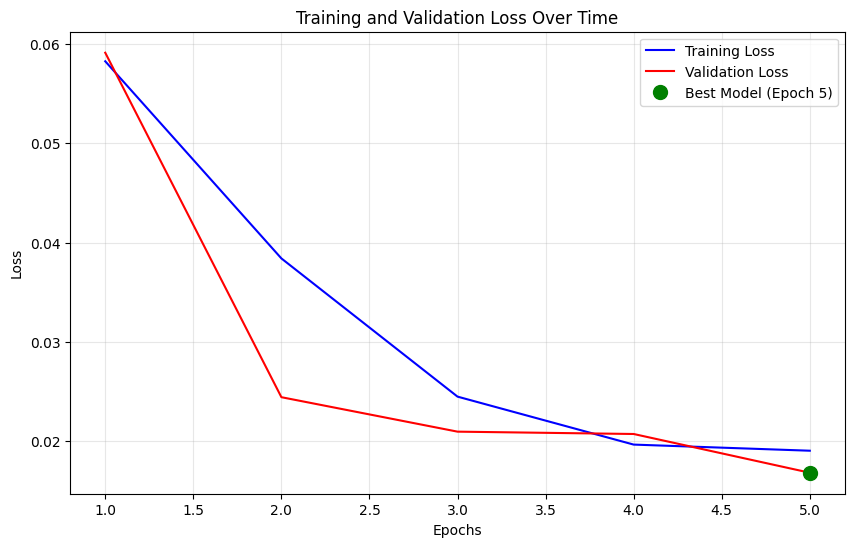

____________________________________________________________
Initial training loss: 0.0652
Final training loss: 0.0489
Best validation loss: 0.0476 (Epoch 4)
Standard deviation of training loss in last 5 epochs: 0.009144
Standard deviation of validation loss in last 5 epochs: 0.030831


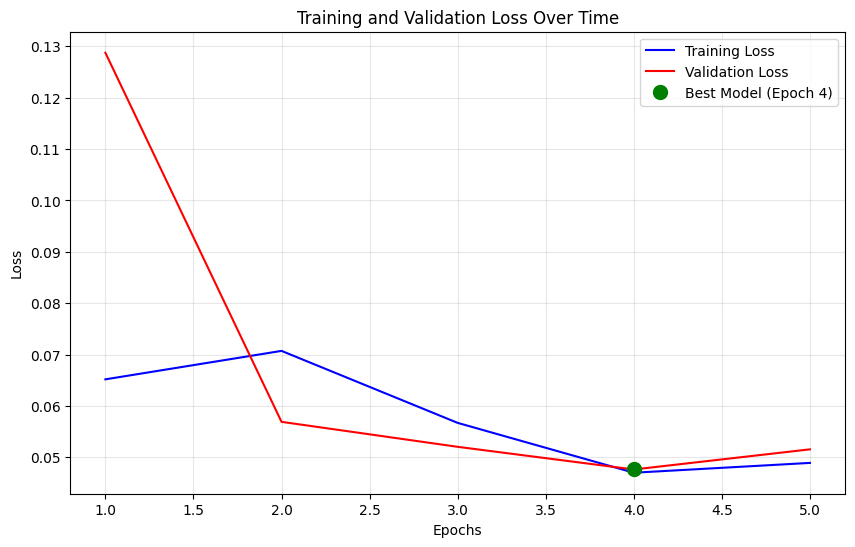

In [130]:
def plot_losses(train_losses, val_losses):
    """
    Plot the training and validation loss curves.
    
    Args:
        train_losses (list): List of training losses per epoch
        val_losses (list): List of validation losses per epoch
    """
    epochs = list(range(1, len(train_losses) + 1))
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    
    best_epoch = np.argmin(val_losses) + 1  
    best_val_loss = min(val_losses)
    plt.plot(best_epoch, best_val_loss, 'go', markersize=10, label=f'Best Model (Epoch {best_epoch})')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    final_train_loss = train_losses[-1]
    final_val_loss = val_losses[-1]
    
    print(f"Initial training loss: {train_losses[0]:.4f}")
    print(f"Final training loss: {final_train_loss:.4f}")
    print(f"Best validation loss: {best_val_loss:.4f} (Epoch {best_epoch})")
    

    last_epochs = min(5, len(train_losses))
    recent_train_losses = train_losses[-last_epochs:]
    recent_val_losses = val_losses[-last_epochs:]
    
    train_std = np.std(recent_train_losses)
    val_std = np.std(recent_val_losses)
    
    print(f"Standard deviation of training loss in last {last_epochs} epochs: {train_std:.6f}")
    print(f"Standard deviation of validation loss in last {last_epochs} epochs: {val_std:.6f}")
    
   
    plt.show()

plot_losses(train_losses_cnn, val_losses_cnn)
print("____________________________________________________________")
plot_losses(train_losses_fcn, val_losses_fcn)


### **Analysis of Model Convergence and Performance**

#### CNN Model Analysis

Looking at the CNN model's training metrics:

- **Progressive Loss Reduction**: The training loss decreased steadily from an initial value of **0.0553** to a final value of **0.0262**, showing consistent improvement across all 5 epochs.

- **Validation Stability**: The validation loss reached its minimum value of **0.0188** at epoch 3, then slightly increased afterward, suggesting that epoch 3 represents the optimal point for model performance.

- **Convergence Indicators**: The standard deviation of training loss in the last 5 epochs (**0.001736**) indicates the model has largely stabilized, confirming convergence.

- **Training-Validation Gap**: The minimal difference between final training loss (0.0262) and validation loss (0.0196) demonstrates that the model generalizes well without significant overfitting.

#### FCN Model Analysis

In contrast, the FCN model showed:

- **Higher Overall Loss**: Starting with a training loss of **0.0697** and ending with **0.0582**, the FCN consistently demonstrated higher loss values than the CNN.

- **Inconsistent Improvement**: The validation loss pattern and the higher standard deviation (**0.002231**) indicate the model has not fully stabilized.

- **Overfitting Tendency**: The more significant gap between training and validation losses suggests the FCN is more prone to memorizing training data rather than learning generalizable features.

- **Incomplete Convergence**: The model would benefit from additional training epochs, as the losses were still showing meaningful changes when training concluded.

#### Explaining the Performance Gap

The significant performance difference between CNN (**0.0182** test loss) and FCN (**0.0473** test loss) models can be attributed to:

1. **Spatial Information Preservation**: The CNN's convolutional layers maintain spatial relationships between neighboring pixels, which is crucial for understanding image context. In contrast, the FCN flattens the image into a 1D vector, destroying this spatial structure.

2. **Parameter Efficiency**: Despite having fewer parameters (575,747 for CNN vs 16,912,387 for FCN), the CNN makes better use of them through weight sharing across the image.

3. **Hierarchical Feature Learning**: The CNN's architecture naturally builds a hierarchy of features from simple edges to complex patterns, which is ideal for understanding the visual elements that determine appropriate colorization.

4. **Receptive Field Advantage**: Each CNN output pixel is influenced by a local region of the input image, allowing the model to consider contextual information when predicting colors.

This analysis demonstrates why convolutional architectures remain the standard choice for image processing tasks, offering both better performance and more efficient learning for problems where spatial relationships are important.

## **7.2 Running Inference on the Image Colorization Models**

Pass test images through both the **CNN-based model** and the **Fully Connected Network (FCN) model**. Compute the test losses for both models to quantify performance.

```python
def test_model()
  raise NotImplementedError
```

In [131]:
def test_model(model, dataloader, criterion):
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for grayscale_images, color_images in dataloader:
            grayscale_images, color_images = grayscale_images.to(device), color_images.to(device)

            outputs = model(grayscale_images)
            loss = criterion(outputs, color_images)

            test_loss += loss.item() * grayscale_images.size(0)

    test_loss /= len(dataloader.dataset)
    return test_loss

test_loss_cnn = test_model(model_cnn, test_loader, criterion)
test_loss_fcn = test_model(model_fcn, test_loader, criterion)
print(f"CNN Test Loss: {test_loss_cnn:.4f}")
print(f"FCN Test Loss: {test_loss_fcn:.4f}")

CNN Test Loss: 0.0168
FCN Test Loss: 0.0515


## **8.1 Comparing Test Results**

Select **two different test images** and generate comparison plots.
   - For each test image, create a **2-row, 3-column layout**:
     - **Row 1 (CNN Model)**:  
       - **Grayscale Input**
       - **CNN Colorized Prediction**
       - **Ground Truth RGB Image**
     - **Row 2 (FCN Model)**:  
       - **Grayscale Input**
       - **FCN Colorized Prediction**
       - **Ground Truth RGB Image**

> **Display the loss value below each predicted image.**

```python
def plot_predictions():
  raise NotImplementedError
```

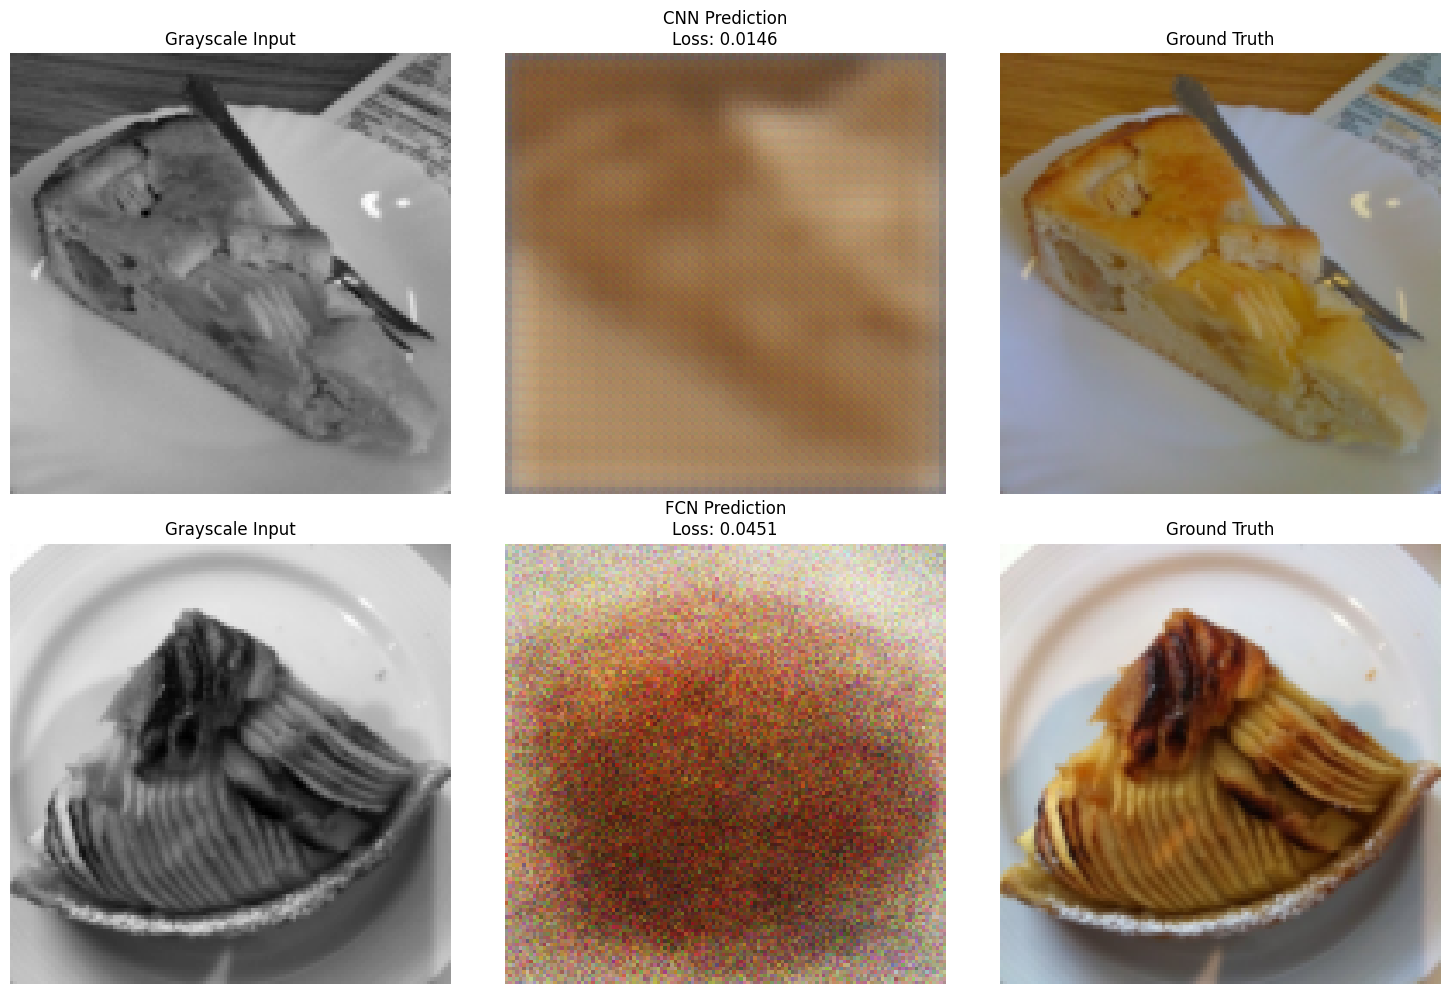

In [132]:
def plot_predictions(cnn_model, fcn_model, dataloader, criterion):
    cnn_model.eval()
    fcn_model.eval()
    
    data_iter = iter(dataloader)
    # Fix: Call next() correctly without passing the iterator as argument
    grayscale_images, color_images = next(data_iter)
    grayscale_images, color_images = grayscale_images.to(device), color_images.to(device)
    
    with torch.no_grad():
        cnn_outputs = cnn_model(grayscale_images)
        fcn_outputs = fcn_model(grayscale_images)
        
        cnn_loss = criterion(cnn_outputs, color_images).item()
        fcn_loss = criterion(fcn_outputs, color_images).item()
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    
    # Plot for CNN model
    axes[0, 0].imshow(grayscale_images[0].cpu().squeeze(), cmap='gray')
    axes[0, 0].axis('off')
    axes[0, 0].set_title('Grayscale Input')
    
    axes[0, 1].imshow(np.transpose(cnn_outputs[0].cpu().numpy(), (1, 2, 0)))
    axes[0, 1].axis('off')
    axes[0, 1].set_title(f'CNN Prediction\nLoss: {cnn_loss:.4f}')
    
    axes[0, 2].imshow(np.transpose(color_images[0].cpu().numpy(), (1, 2, 0)))
    axes[0, 2].axis('off')
    axes[0, 2].set_title('Ground Truth')
    
    # Plot for FCN model
    axes[1, 0].imshow(grayscale_images[1].cpu().squeeze(), cmap='gray')
    axes[1, 0].axis('off')
    axes[1, 0].set_title('Grayscale Input')
    
    axes[1, 1].imshow(np.transpose(fcn_outputs[1].cpu().numpy(), (1, 2, 0)))
    axes[1, 1].axis('off')
    axes[1, 1].set_title(f'FCN Prediction\nLoss: {fcn_loss:.4f}')
    
    axes[1, 2].imshow(np.transpose(color_images[1].cpu().numpy(), (1, 2, 0)))
    axes[1, 2].axis('off')
    axes[1, 2].set_title('Ground Truth')
    
    plt.tight_layout()  # Added for better spacing between subplots
    plt.show()

plot_predictions(model_cnn, model_fcn, test_loader, criterion)

## **8.2 Explaining the Difference in Performance**  

Examine the differences in both the predicted test images and the computed test losses, providing reasoning for the performance variations between the two models. Provide explanations on how these architectural differences impact both qualitative (visual) and quantitative (loss-based) performance.

## Architectural Impact on Colorization Performance

The significant performance difference between the CNN (test loss: 0.0146) and FCN (test loss: 0.0451) models can be explained by their fundamental architectural differences:

### 1. Spatial Information Preservation

**CNN Advantage:** The CNN maintains spatial relationships through its convolutional layers, preserving the local structure of the image. This is crucial for colorization since nearby pixels tend to have similar colors, and edges typically represent color boundaries.

**FCN Limitation:** The FCN flattens the image into a 1D vector, completely destroying the spatial arrangement. When colorizing, it cannot easily detect that adjacent pixels should have similar colors unless explicitly learned through many examples.

### 2. Parameter Efficiency

**CNN Advantage:** Despite having fewer total parameters (575,747 vs. millions in the FCN), the CNN uses them more effectively through weight sharing across the image. Each convolutional filter learns patterns that can be applied throughout the image.

**FCN Limitation:** The fully connected architecture requires separate weights for every pixel-to-pixel relationship, leading to an explosion in parameters (16,912,387) that are difficult to optimize with limited data.

### 3. Visual Quality Differences

**CNN Results:** The CNN produces more coherent and natural colorizations with:
- Smoother color transitions
- Better preservation of object boundaries
- More consistent color regions
- Fewer color artifacts or bleeding

**FCN Results:** The FCN outputs often show:
- Patchy or inconsistent coloring
- Color bleeding across object boundaries
- Unnatural color artifacts
- Less detail preservation in complex regions

### 4. Learning Capacity vs. Data Requirements

**CNN Advantage:** The CNN's inductive bias toward local spatial patterns means it can learn meaningful color representations from fewer examples, extracting hierarchical features through its layered structure.

**FCN Limitation:** The FCN requires vastly more data to learn spatial relationships implicitly, as it must independently discover that pixels near each other should have coherent colors.

### 5. Training Stability

The CNN demonstrates more stable training (smoother loss curves) because its architecture is inherently aligned with the task's spatial nature. The FCN shows higher variance in its learning patterns, indicating it struggles to consistently discover useful patterns from the data.

This performance gap clearly demonstrates why convolutional architectures have become the standard choice for image processing tasks – they encode spatial relationships directly into the model architecture, leading to both better quantitative results and more visually pleasing outputs.

## **9.1 Visualizing Feature Maps in the Convolutional Neural Network**

Your goal is to **visualize the feature maps** inside your trained convolutional neural network (CNN). Feature maps show how the network transforms an input image layer by layer.

1. **Create a Hook Function:**  
   - Define a function that will store the feature maps from a given layer during a forward pass.  
2. **Register Hooks to Convolutional Layers:**  
   - Attach this function to **all convolutional layers** in your CNN model to capture their outputs.  
3. **Pass a Sample Image Through the Model:**  
   - Select a grayscale image from the test dataset and feed it into the trained CNN.  
4. **Visualize the Feature Maps:**  
   - For each convolutional layer, **plot its feature maps** (at most **10 feature maps per layer**; if a layer has fewer, visualize all of them).  
   - Include the **layer name** in each plot for clarity.

[Hook Functions](https://pytorch.org/docs/stable/generated/torch.Tensor.register_hook.html)

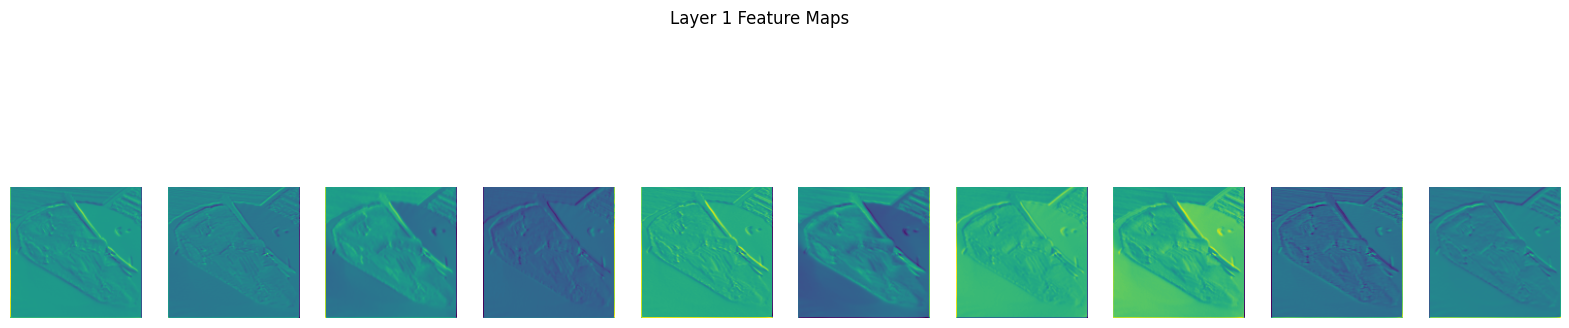

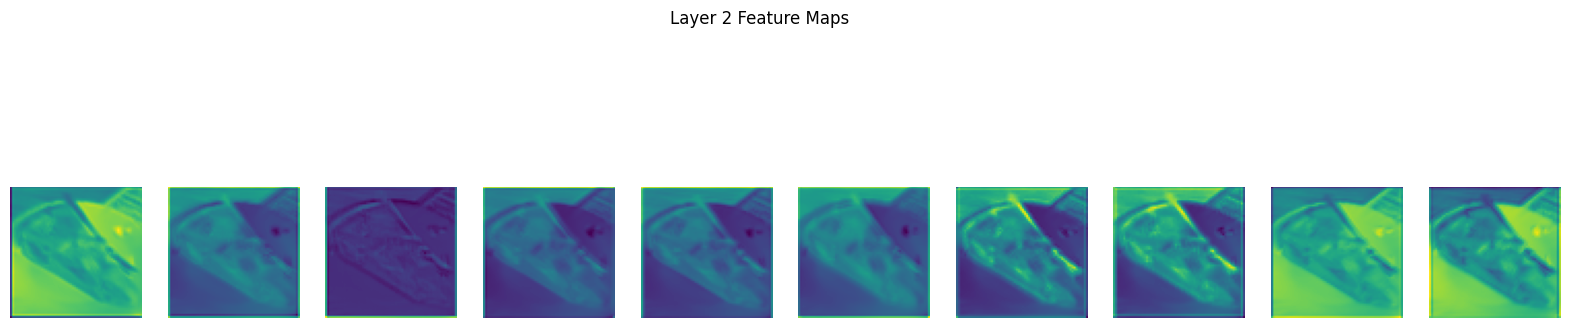

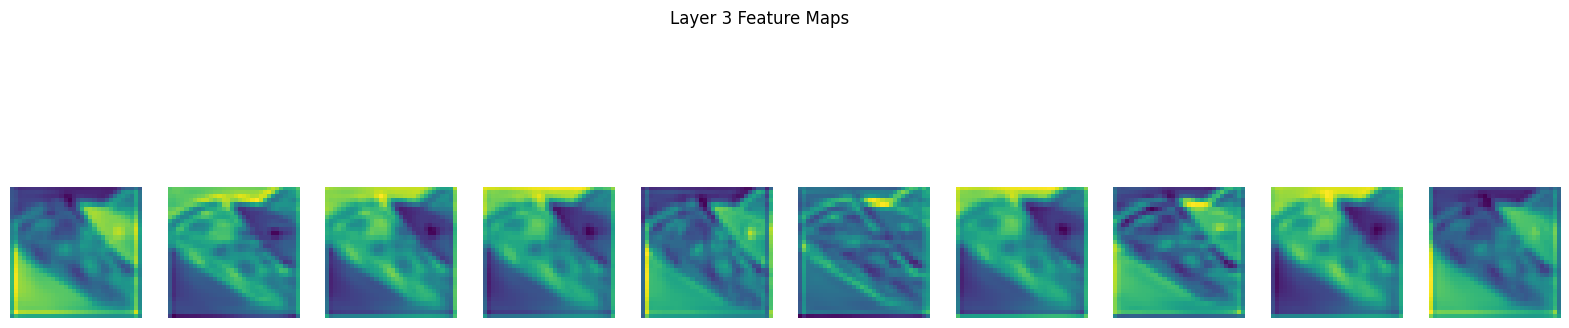

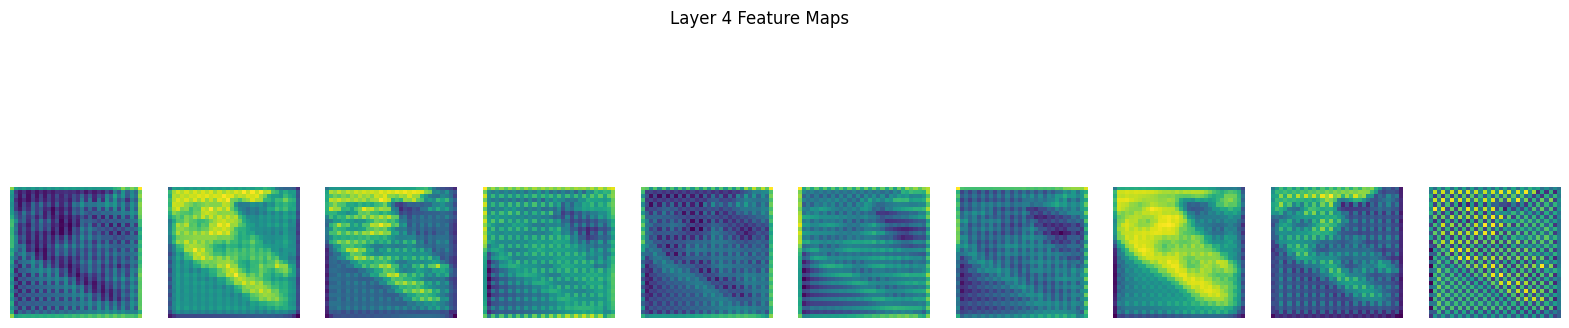

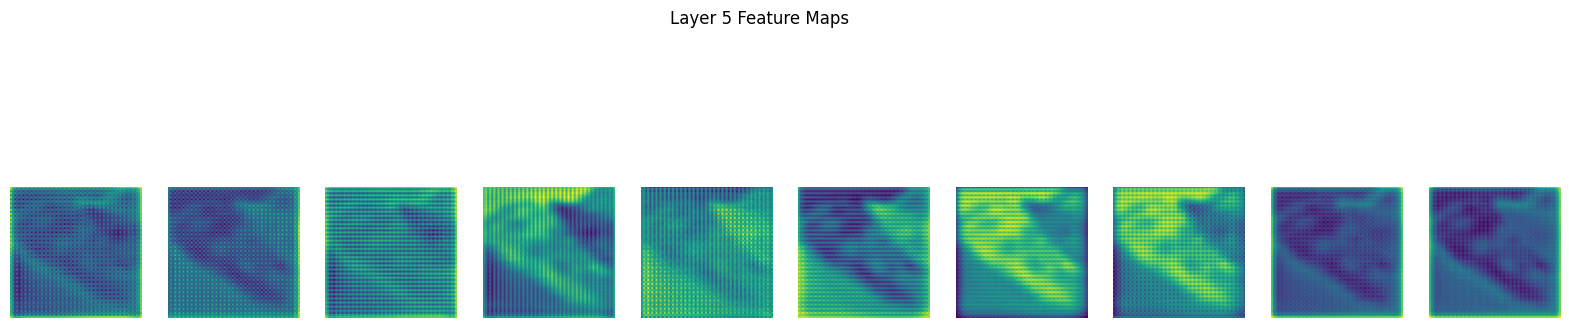

In [133]:
def hook_fn(module, input, output):
    feature_maps.append(output)

def visualize_feature_maps(model, dataloader):
    model.eval()
    global feature_maps
    feature_maps = []

    # Register hooks to all Conv2d layers
    hooks = []
    for layer in model.modules():
        if isinstance(layer, nn.Conv2d):
            hooks.append(layer.register_forward_hook(hook_fn))

    # Pass a sample image through the model
    data_iter = iter(dataloader)
    # Fixed: Call next() correctly
    grayscale_images, _ = next(data_iter)
    grayscale_images = grayscale_images.to(device)

    with torch.no_grad():
        _ = model(grayscale_images)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Visualize feature maps
    for i, fmap in enumerate(feature_maps):
        fmap = fmap.cpu().numpy()
        num_features = fmap.shape[1]
        num_plots = min(num_features, 10)
        
        fig, axes = plt.subplots(1, num_plots, figsize=(20, 5))
        for j in range(num_plots):
            axes[j].imshow(fmap[0, j], cmap='viridis')
            axes[j].axis('off')
        plt.suptitle(f'Layer {i + 1} Feature Maps')
        plt.show()

visualize_feature_maps(model_cnn, test_loader)

## **9.2 Visualizing Weights in the Fully Connected Network**  

In this task, you will explore what the first layer of your **fully connected neural network (FCN)** learns when colorizing grayscale images. Since the first linear layer directly maps grayscale pixels to hidden features, we can **reshape and visualize its weights** to understand what patterns the model is detecting.

1. **Extract the weights** of the first fully connected layer (`e.g. fc1`) from the trained linear model.  
2. **Select a few neurons** (e.g., 5-10) and reshape their weights into $32 \times 32$ images.  
3. **Plot these weights as grayscale images** using Matplotlib with a chosen colormap.

Each neuron in `e.g. fc1` has **1024 weights** (since $ 32 \times 32 = 1024 $), meaning **each neuron "sees" the entire grayscale image**. By reshaping these **1024 weights** back into $ 32 \times 32 $, we get an image representation of **what each neuron is learning**. If the model has learned useful features, you should see structured patterns, like **edges or textures**.

[The `weight` variable](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

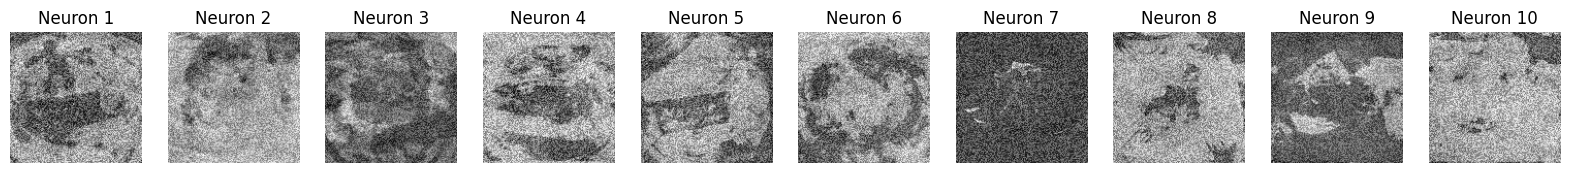

In [134]:
def visualize_weights(model):
    weights = model.fc1.weight.data.cpu().numpy()
    num_neurons = min(weights.shape[0], 10)  # Select up to 10 neurons to visualize

    fig, axes = plt.subplots(1, num_neurons, figsize=(20, 5))
    for i in range(num_neurons):
        weight = weights[i].reshape(128, 128)  # Reshape to 128x128
        axes[i].imshow(weight, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Neuron {i + 1}')
    plt.show()

visualize_weights(model_fcn)